# Forsetti Fraud Detection Classifier
### Finding fradulent records in banking transactions

## Background

This classifier was built as a side project to see if we could:
1. detect fraudulent transactions in banking information
2. evaluate several classification techniques (Random Forest, Keras ANN, Naive Bayes) to see which one is most accurate
3. evaluate two imbalance handling techniques (class weighting and Statistical Minority Oversampling Technique (SMOTE)) to see which one performs best.

## About the Data

The data is sourced from: [IEEE-CIS Fraud Detection](https://www.kaggle.com/c/ieee-fraud-detection "IEEE CIS Fraud Detection"), which includes a transactions dataset and an identities dataset.

## About Data Preparation

We tried to build the training dataset two ways: 
* Fusing both the transaction and identity datasets together on `TransactionID` using an outer join.
* Just using the transactional dataset 

I didn't see any marked improvment when adding the identities in (especially given the compute requirements), so I've use left the transactions dataset as the training set

## Structure of this notebook

This notebook is broken up into the following sections:
1. Imports
2. Notebook configuration
3. Custom Functions
4. Data Exploration
5. Data Preparation
6. Imbalanced classes
    1. Artificial Neural Network Training
    2. Random Forest Training
    3. Naive Bayes
7. Balanced Class Training (SMOTE)
    1. Oversampling
    2. Artificial Neural Network Training
    3. Random Forest Training
    4. Naive Bayes
    
After each model is trained, we save it out to disk using joblib

Happy Learning!

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from IPython.core.display import display, HTML
import seaborn as sns
from tensorflow.keras.layers import Dense, Dropout, Activation, Input
from tensorflow.keras.callbacks import EarlyStopping,  ModelCheckpoint, TensorBoard
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model, load_model
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from IPython.core.display import display, HTML
import seaborn as sns
import pandas as pd
import numpy as np
import joblib
import lime
import lime.lime_tabular
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE

Using TensorFlow backend.


### Set up the display width and SNS colourizations

In [2]:
display(HTML("<style>.container { width:90% !important; }</style>"))
sns.set(color_codes=True)

In [3]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 500)

## Functions

In [4]:
def find_strings(dataset):
    '''Function that finds how many columns in a dataframe that contain strings. Returns the unique list of column names.
    Used for determining which columns should be label encoded.

    Inputs: dataframe
    Returns: list of unique column names'''
    string_columns = []
    columns = dataset.columns
    for column in tqdm(columns):
        types = dataset[column].apply(type)
        for row in types:
            if (row) == str:
                string_columns.append(column)
    string_columns = np.array(string_columns)
    return np.unique(string_columns)


def show_nan_distribution(dataset):
    '''Function to show how many NANs are in each column. Used for determining which columns support being dropped before encoding.

    Inputs: dataframe
    Returns: Lineplot'''

    dataset_nans = dataset.isna().sum()
    plt.figure(num=None, figsize=(30, 20), dpi=320)
    plt.xticks(rotation=90)
    plt.grid(b=None)
    plt.plot(dataset_nans.index, dataset_nans)
    plt.show()


def drop_high_nans(dataset, drop_value):
    '''Function that creates a list of columns to drop based on a threshold of how many NANs are in the column.

    Inputs: dataframe, drop_value
    Returns: drop_cols (list)'''
    drop_cols = []
    dataset = dataset.isna().sum()
    for i in tqdm(range(0, len(dataset))):
        if dataset[i] > drop_value:
            drop_cols.append(dataset.index[i])
    return drop_cols


def drop_high_nan_rows(dataset, drop_value):
    drop_cols = []
    dataset = dataset.isna().sum()
    for i in tqdm(range(0, len(dataset))):
        if dataset[i] > drop_value:
            drop_cols.append(dataset.index[i])
    return drop_cols


def get_class_weights(y):
    '''Function to determine class imbalance in a binary labels. Used to feed class_weights in ML models.

    Inputs: y
    Returns: class_weight dict'''

    counter = Counter(y)
    majority = max(counter.values())
    return {cls: round(float(majority)/float(count), 2) for cls, count in counter.items()}


def evaluate_model(y_test, y_pred):
    '''Function that calls SKLearns confusion matrix and classification report to evaluate model performance.

    Inputs: y_test (or y_true), y_pred'''

    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))

## Data Exploration

For this part of the experiment, we load up and join both the test and training datasets as we want to be able to look at them together later (predicting on both the test and training sets).

We will load both datasets, join them, then drop original ones to save memory.

In [5]:
train_transactions = pd.read_csv("./data/train_transaction.csv")
test_transactions = pd.read_csv("./data/test_transaction.csv")
fused_dataset = pd.concat([test_transactions, train_transactions])

/Users/carl.sharpe/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


In [6]:
print(fused_dataset.shape)
display(fused_dataset.head())

(1097231, 394)


,C1,C10,C11,C12,C13,C14,C2,C3,C4,C5,C6,C7,C8,C9,D1,D10,D11,D12,D13,D14,D15,D2,D3,D4,D5,D6,D7,D8,D9,M1,M2,M3,M4,M5,M6,M7,M8,M9,P_emaildomain,ProductCD,R_emaildomain,TransactionAmt,TransactionDT,TransactionID,V1,V10,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V11,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V12,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V13,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V14,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V15,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V16,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V17,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V18,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V19,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V2,V20,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V21,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V22,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V23,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V24,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V25,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V26,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V27,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V28,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V29,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V3,V30,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V31,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V32,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V33,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,V34,V35,V36,V37,V38,V39,V4,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V5,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V6,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V7,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V8,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V9,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,addr1,addr2,card1,card2,card3,card4,card5,card6,dist1,dist2,isFraud
0,6.0,0.0,5.0,1.0,115.0,6.0,6.0,0.0,0.0,3.0,4.0,0.0,0.0,6.0,419.0,418.0,203.0,NaN,NaN,NaN,409.0,419.0,27.0,398.0,27.0,NaN,NaN,NaN,NaN,T,T,F,NaN,NaN,F,T,T,T,gmail.com,W,NaN,31.95,18403224,3663549,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,47.950001,0.000000,0.000000,0.0,47.950001,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,47.950001,0.000000,0.000000,0.0,47.950001,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,170.0,87.0,10409,111.0,150.0,visa,226.0,debit,1.0,NaN,NaN
1,3.0,0.0,1.0,1.0,12.0,2.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,149.0,231.0,634.0,NaN,NaN,NaN,634.0,149.0,7.0,634.0,7.0,NaN,NaN,NaN,NaN,T,F,F,M0,NaN,F,NaN,NaN,NaN,aol.com,W,NaN,49.00,18403263,3663550,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,280.000000,77.000000,0.000000,1.0,280.000000,77.000000,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

## Data Preparation
### Finding sparsely populated columns to drop

Here's we're going to look at the dataset a bit more deeply to see how things are distributed. We also will focus on the Fraudulent transactions because we're more concerned with detecting potentially fraudulent vs non-fraudulent transactions.

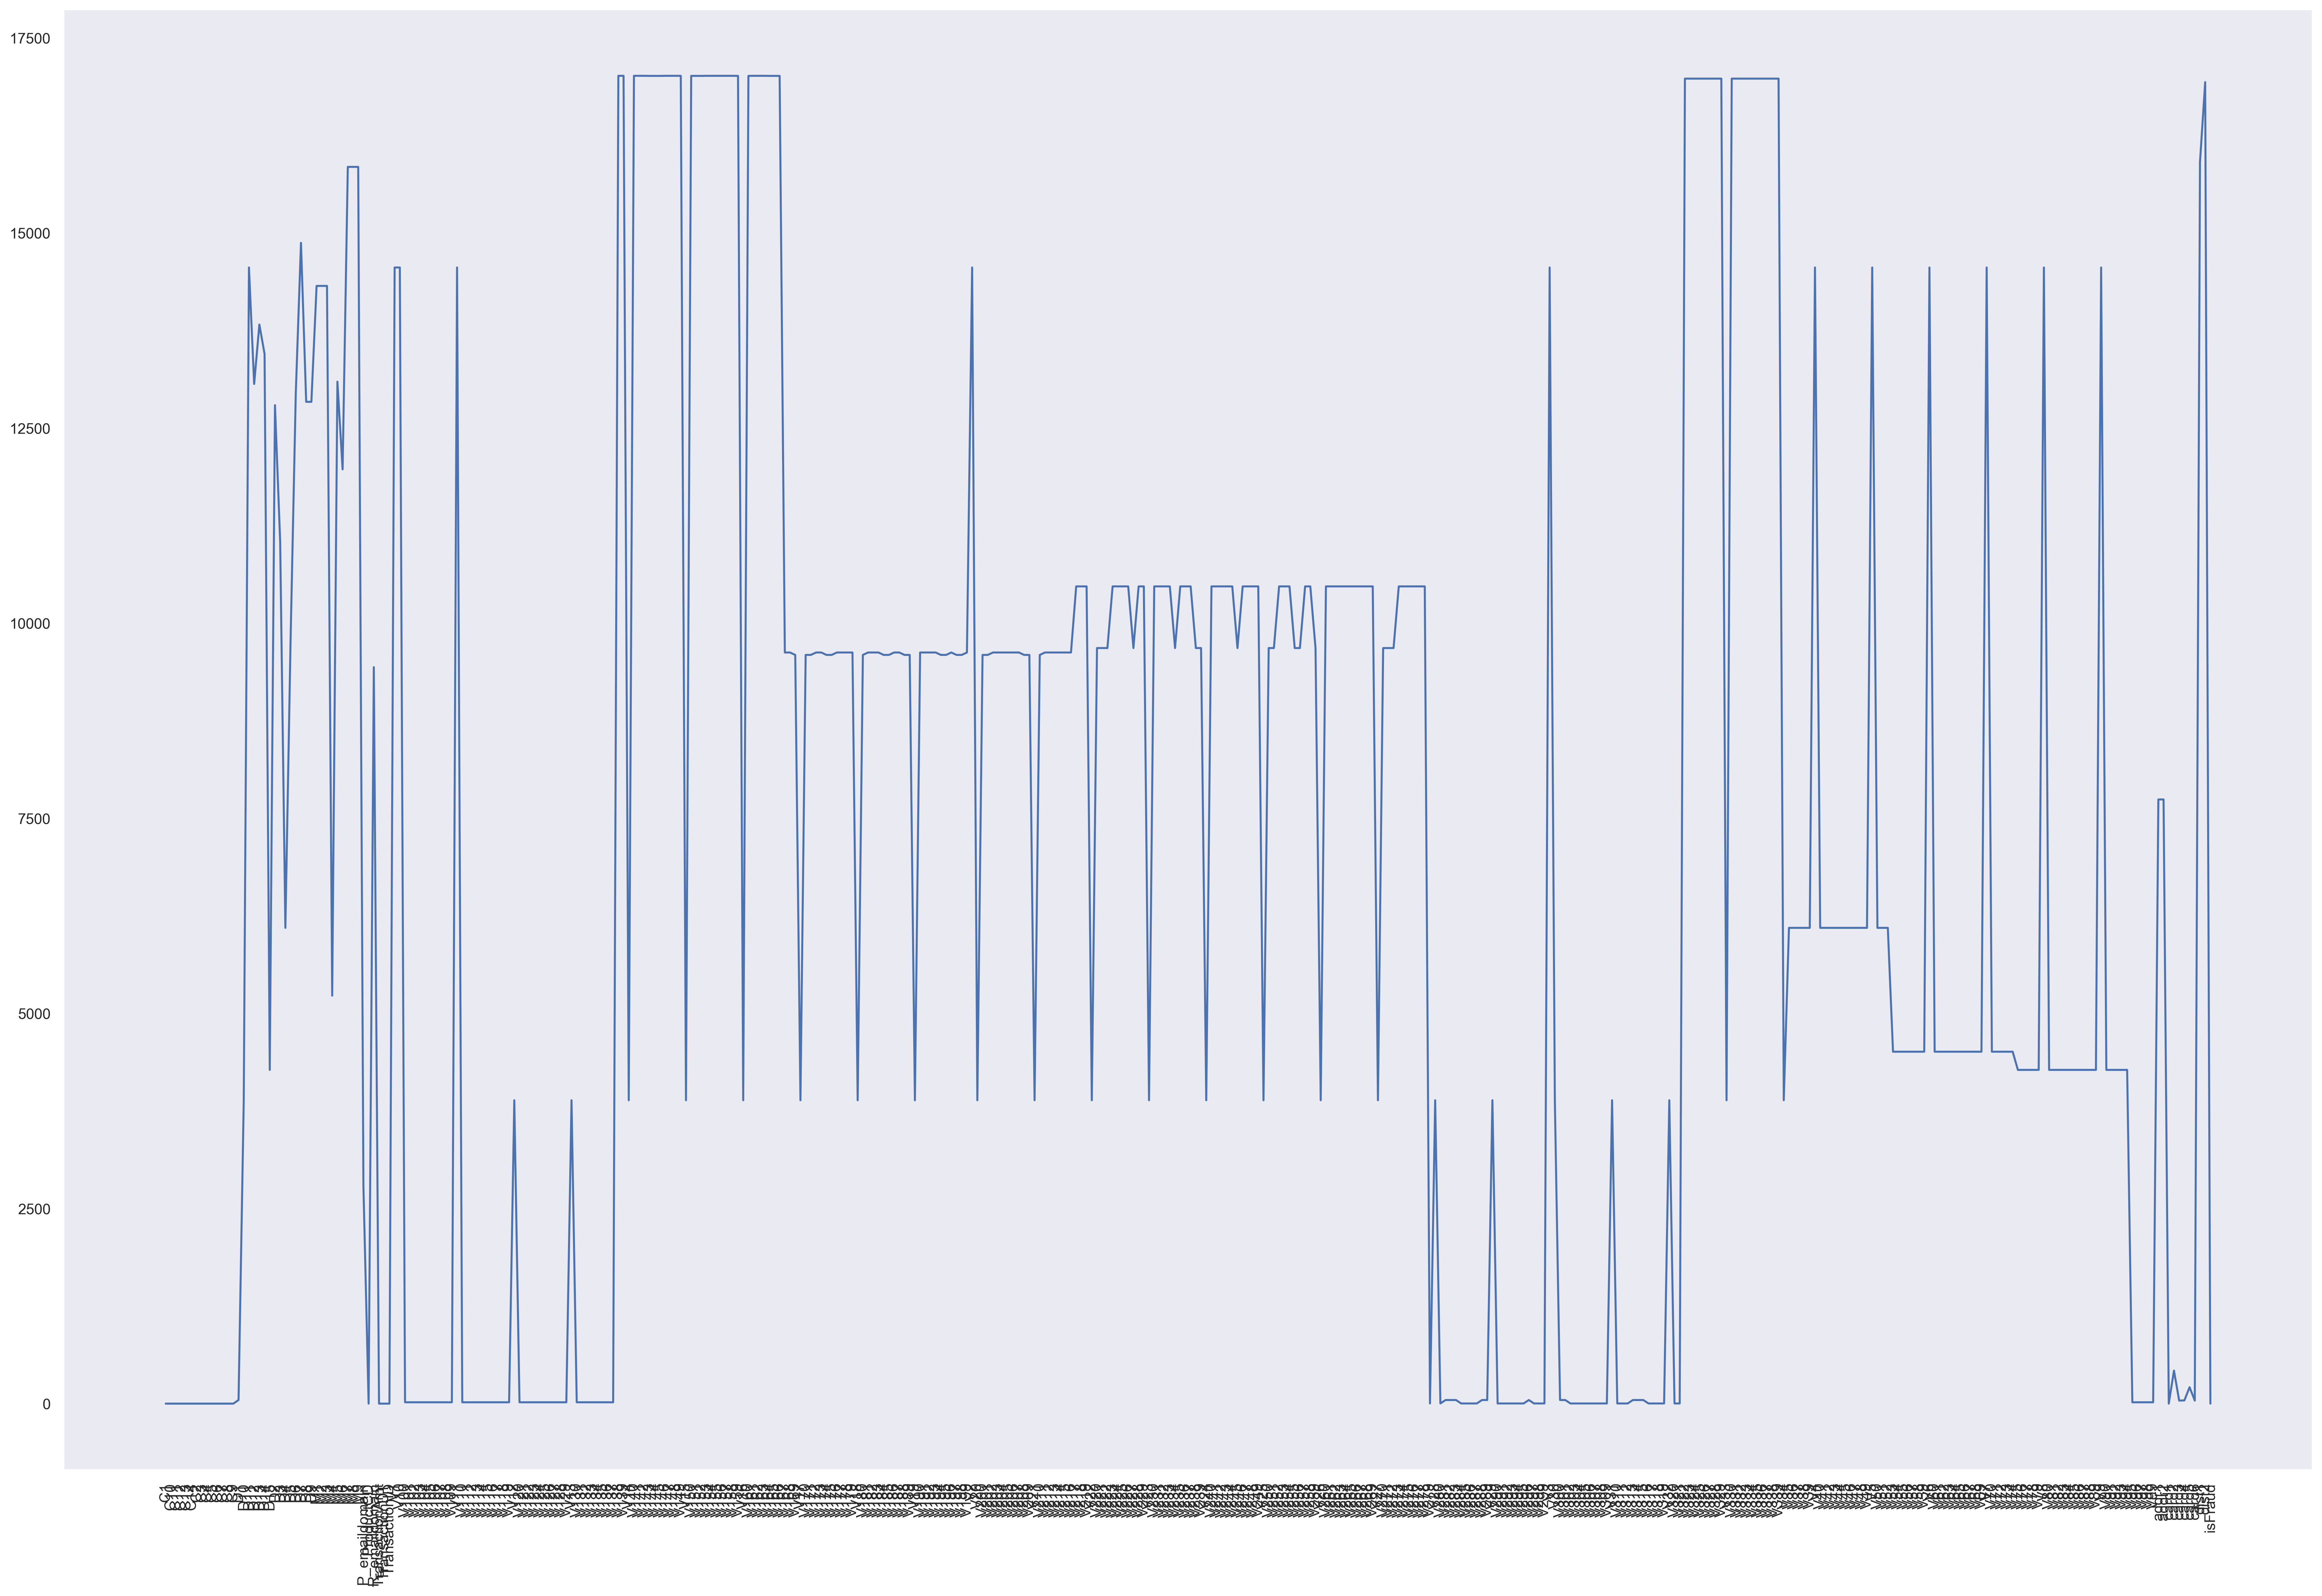

In [7]:
show_nan_distribution(fused_dataset[fused_dataset['isFraud'] == 1])

In [8]:
train_transactions = fused_dataset[fused_dataset['isFraud'].isna() == False]

In [9]:
train_transactions.head()

,C1,C10,C11,C12,C13,C14,C2,C3,C4,C5,C6,C7,C8,C9,D1,D10,D11,D12,D13,D14,D15,D2,D3,D4,D5,D6,D7,D8,D9,M1,M2,M3,M4,M5,M6,M7,M8,M9,P_emaildomain,ProductCD,R_emaildomain,TransactionAmt,TransactionDT,TransactionID,V1,V10,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V11,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V12,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V13,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V14,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V15,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V16,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V17,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V18,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V19,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V2,V20,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V21,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V22,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V23,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V24,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V25,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V26,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V27,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V28,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V29,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V3,V30,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V31,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V32,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V33,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,V34,V35,V36,V37,V38,V39,V4,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V5,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V6,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V7,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V8,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V9,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,addr1,addr2,card1,card2,card3,card4,card5,card6,dist1,dist2,isFraud
0,1.0,0.0,2.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,14.0,13.0,13.0,NaN,NaN,NaN,0.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,T,T,T,M2,F,T,NaN,NaN,NaN,NaN,W,NaN,68.5,86400,2987000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,1.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,315.0,87.0,13926,NaN,150.0,discover,142.0,credit,19.0,NaN,0.0
1,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN,gmail.com,W,NaN,29.0,86401,2987001,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

### Encoding
* Identify columns that need to be encoded
* encode them

In [10]:
string_columns = find_strings(train_transactions)

100%|██████████| 394/394 [00:58<00:00,  6.73it/s]


In [11]:
train_transactions_categorical_columns = [
    'ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain'] + string_columns.tolist()

In [12]:
categorical_transactions_dataset = pd.get_dummies(
    train_transactions, columns=train_transactions_categorical_columns, drop_first=True)

In [13]:
y = categorical_transactions_dataset.isFraud.values
categorical_transactions_dataset.drop(columns=['isFraud', 'TransactionID'], inplace=True)

In [14]:
categorical_transactions_dataset.fillna(0, inplace=True)

## Preparing X and y, Splitting and Scalling

In [15]:
X = categorical_transactions_dataset.values #drop identifying column(s)

In [16]:
X.shape

(590540, 642)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

## Scaling

We feature scale the data here to reduce the value of outlier (very high or very low) numbers.
We fit it on the X_train values only to avoid potentially biasing the scaler with the test data

In [18]:
sc = StandardScaler()
sc.fit(X_train)
X_train = sc.transform(X_train)
X_test = sc.transform(X_test)

### Class Weighting

We have two classes here:
* 0 (Non-Fraudulent)
* 1 (Fraudulent)

Around 96% of the data is non-fraudulent, so we need to tell the classifier(s) to value the fraudulent class more to avoid ending up with a classifier that only predicts the majority class. This works well with Keras but I haven't had much success with Random Forest.

In [19]:
class_weights = get_class_weights(y_train)
print(class_weights)

{0.0: 1.0, 1.0: 27.44}


## Setting up the ANN. 
This is really experimental in nature. I have found that ANN's with an initial broader hidden layer followed by several smaller layers generalize well. You can play with the configuration here or make your own.

We also put in a dropout layer you can read more here [Dropout Regularization in Deep Learning Models With Keras](https://machinelearningmastery.com/dropout-regularization-deep-learning-models-keras/)

In [20]:
input_dim = X_train.shape[1]
num_hidden_layers = 2
layers = []
input_layer = input_dim

for i in range(0, num_hidden_layers):
    if i == 0:
        layers.append(int(input_dim*1.75))
    else:
        layers.append(int(layers[i-1] / 1.5))

In [21]:
layers

[1123, 748]

In [22]:
ann_model = Sequential()
ann_model.add(Dense(layers[0], input_dim=input_dim, activation='relu'))
ann_model.add(Dropout(0.4))
for i in range(1, len(layers)):
    if i == 2:
        ann_model.add(Dropout(0.3))
    ann_model.add(Dense(layers[i], activation='relu'))

ann_model.add(Dense(1, activation='sigmoid'))

ann_model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
print(ann_model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1123)              722089    
_________________________________________________________________
dropout (Dropout)            (None, 1123)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 748)               840752    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 749       
Total params: 1,563,590
Trainable params: 1,563,590
Non-trainable params: 0
_________________________________________________________________
None


In [23]:
# We set up callbacks here so that we can set a lot of epochs in the training and the callback will check to see if it is still learning or if it's done.
es = [EarlyStopping(monitor='accuracy', mode='auto', verbose=1,
                    patience=2)]

## Spoiler alert. 
When we train with the standard weighting we get around 80% accuracy (see below) on the fraud set. We want to boost that so we will arbitrarily increase the class weight of the fraud set.
```
[[106725   7331]
 [   798   3254]]
              precision    recall  f1-score   support

         0.0       0.99      0.94      0.96    114056
         1.0       0.31      0.80      0.44      4052

    accuracy                           0.93    118108
   macro avg       0.65      0.87      0.70    118108
weighted avg       0.97      0.93      0.95    118108
```

In [24]:
class_weights_custom = {0: 1.0, 1: 46}

In [25]:
history = ann_model.fit(X_train,
                        y_train,
                        epochs=1000,
                        batch_size=1000,
                        verbose=1,
                        class_weight=class_weights_custom,
                        callbacks=es
                        )

Train on 472432 samples
Epoch 1/1000
472432/472432 [==============================] - 28s 60us/sample - loss: 1.1907 - accuracy: 0.6772
Epoch 2/1000
472432/472432 [==============================] - 27s 58us/sample - loss: 1.0628 - accuracy: 0.7261
Epoch 3/1000
472432/472432 [==============================] - 28s 59us/sample - loss: 1.0107 - accuracy: 0.7473
Epoch 4/1000
472432/472432 [==============================] - 28s 60us/sample - loss: 0.9657 - accuracy: 0.7631
Epoch 5/1000
472432/472432 [==============================] - 29s 61us/sample - loss: 0.9259 - accuracy: 0.7743
Epoch 6/1000
472432/472432 [==============================] - 29s 61us/sample - loss: 0.8948 - accuracy: 0.7847
Epoch 7/1000
472432/472432 [==============================] - 29s 61us/sample - loss: 0.8603 - accuracy: 0.7951
Epoch 8/1000
472432/472432 [==============================] - 28s 59us/sample - loss: 0.8241 - accuracy: 0.8032
Epoch 9/1000
472432/472432 [==============================] - 28s 59us/sample - 

In [26]:
# Now let's evaluate the model on the test data
y_pred = ann_model.predict_classes(X_test)

In [27]:
evaluate_model(y_test, y_pred)

[[104411   9645]
 [   685   3367]]
              precision    recall  f1-score   support

         0.0       0.99      0.92      0.95    114056
         1.0       0.26      0.83      0.39      4052

    accuracy                           0.91    118108
   macro avg       0.63      0.87      0.67    118108
weighted avg       0.97      0.91      0.93    118108



In [28]:
joblib.dump(sc, 'scaler.pickle')

['scaler.pickle']

In [29]:
ann_model.save('ann_transactions_model.h5')

# Random Forest Classifier

The [Random Forest Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) is an ensemble classifier that uses several decision trees to predict y given various X inputs.

In [30]:
class_weights = {0: 0.036, 1: 1} # RF Classifier appears to only weight to 1, so we've divided the weights here

In [31]:
rf_model = RandomForestClassifier(n_estimators=100, verbose=1, class_weight=class_weights, n_jobs=-1, bootstrap=False, random_state=42 )

In [32]:
rf_model.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.5min finished


RandomForestClassifier(bootstrap=False, ccp_alpha=0.0,
                       class_weight={0: 0.036, 1: 1}, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=-1, oob_score=False,
                       random_state=42, verbose=1, warm_start=False)

In [33]:
rf_predictions = rf_model.predict(X_test)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.9s finished


In [34]:
evaluate_model(y_test, rf_predictions)

[[113916    140]
 [  2137   1915]]
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99    114056
         1.0       0.93      0.47      0.63      4052

    accuracy                           0.98    118108
   macro avg       0.96      0.74      0.81    118108
weighted avg       0.98      0.98      0.98    118108



# Training on Over Sampled Data

In [35]:
sm = SMOTE(random_state=42, n_jobs=-1)

In [36]:
X_res, y_res = sm.fit_resample(X_train, y_train)

In [37]:
Counter(y_res)

Counter({0.0: 455821, 1.0: 455821})

In [38]:
ann_model_smote = Sequential()
ann_model_smote.add(Dense(layers[0], input_dim=input_dim, activation='relu'))
ann_model_smote.add(Dropout(0.4))
for i in range(1, len(layers)):
    if i == 2:
        ann_model_smote.add(Dropout(0.3))
    ann_model_smote.add(Dense(layers[i], activation='relu'))

ann_model_smote.add(Dense(1, activation='sigmoid'))

ann_model_smote.compile(optimizer='adam',
                        loss='binary_crossentropy',
                        metrics=['accuracy'])
print(ann_model_smote.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 1123)              722089    
_________________________________________________________________
dropout_1 (Dropout)          (None, 1123)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 748)               840752    
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 749       
Total params: 1,563,590
Trainable params: 1,563,590
Non-trainable params: 0
_________________________________________________________________
None


In [39]:
es = [EarlyStopping(monitor='accuracy', mode='auto', verbose=1,
                    patience=2)]

In [40]:
history = ann_model_smote.fit(X_res,
                              y_res,
                              epochs=200,
                              batch_size=1000,
                              verbose=1,
                              callbacks=es
                              )

Train on 911642 samples
Epoch 1/20
911642/911642 [==============================] - 71s 78us/sample - loss: 0.3412 - accuracy: 0.8471
Epoch 2/20
911642/911642 [==============================] - 60s 65us/sample - loss: 0.2177 - accuracy: 0.9077
Epoch 3/20
911642/911642 [==============================] - 57s 63us/sample - loss: 0.1727 - accuracy: 0.9281
Epoch 4/20
911642/911642 [==============================] - 55s 61us/sample - loss: 0.1447 - accuracy: 0.9408
Epoch 5/20
911642/911642 [==============================] - 56s 62us/sample - loss: 0.1257 - accuracy: 0.9493
Epoch 6/20
911642/911642 [==============================] - 60s 66us/sample - loss: 0.1121 - accuracy: 0.9550
Epoch 7/20
911642/911642 [==============================] - 68s 74us/sample - loss: 0.1012 - accuracy: 0.9597
Epoch 8/20
911642/911642 [==============================] - 62s 68us/sample - loss: 0.0934 - accuracy: 0.9631
Epoch 9/20
911642/911642 [==============================] - 57s 62us/sample - loss: 0.0871 - acc

In [41]:
ann_pred_predictions = ann_model_smote.predict_classes(X_test)
evaluate_model(y_test, ann_pred_predictions)

[[110469   3587]
 [  1004   3048]]
              precision    recall  f1-score   support

         0.0       0.99      0.97      0.98    114056
         1.0       0.46      0.75      0.57      4052

    accuracy                           0.96    118108
   macro avg       0.73      0.86      0.78    118108
weighted avg       0.97      0.96      0.97    118108



In [42]:
rf_model_smote = RandomForestClassifier(
    n_estimators=100, verbose=1, n_jobs=-1, bootstrap=False, random_state=42)

In [43]:
rf_model_smote.fit(X_res, y_res)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 11.4min finished


RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=1,
                       warm_start=False)

In [44]:
rf_smote_predictions = rf_model_smote.predict(X_test)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    2.7s finished


In [45]:
evaluate_model(rf_smote_predictions, y_test)

[[113766   2048]
 [   290   2004]]
              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99    115814
         1.0       0.49      0.87      0.63      2294

    accuracy                           0.98    118108
   macro avg       0.75      0.93      0.81    118108
weighted avg       0.99      0.98      0.98    118108



In [46]:
train_transactions.sort_values(by='TransactionDT', ascending=False).head()

,C1,C10,C11,C12,C13,C14,C2,C3,C4,C5,C6,C7,C8,C9,D1,D10,D11,D12,D13,D14,D15,D2,D3,D4,D5,D6,D7,D8,D9,M1,M2,M3,M4,M5,M6,M7,M8,M9,P_emaildomain,ProductCD,R_emaildomain,TransactionAmt,TransactionDT,TransactionID,V1,V10,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V11,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V12,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V13,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V14,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V15,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V16,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V17,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V18,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V19,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V2,V20,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V21,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V22,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V23,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V24,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V25,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V26,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V27,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V28,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V29,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V3,V30,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V31,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V32,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V33,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,V34,V35,V36,V37,V38,V39,V4,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V5,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V6,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V7,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V8,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V9,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,addr1,addr2,card1,card2,card3,card4,card5,card6,dist1,dist2,isFraud
590539,2.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,0.0,1.0,0.0,NaN,NaN,NaN,1.0,NaN,0.0,1.0,0.0,NaN,NaN,NaN,NaN,T,F,F,NaN,NaN,T,F,F,F,gmail.com,W,NaN,279.95,15811131,3577539,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,279.950012,279.950012,279.950012,0.0,2.0,0.000000,0.0,0.0,0.0,0.0,279.950012,279.950012,279.950012,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,1.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,279.950012,279.950012,279.950012,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,279.950012,0.0,279.950012,279.950012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,2.0,2.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0,2.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,2.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,299.0,87.0,15066,170.0,150.0,mastercard,102.0,credit,NaN,NaN,0.0
590538,1.0,0.0,1.0,1.0,5.0,1.0,1.0,0.0,0.0,0.0,3.0,0.0,0.0,2.0,22.0,22.0,22.0,NaN,NaN,NaN,22.0,22.0,0.0,22.0,0.0,NaN,NaN,NaN,NaN,T,T,T,M0,F,T,NaN,NaN,NaN,aol.com,W,NaN,117.00,15811088,3577538,1.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,117.000000,1035.500000,117.000000,117.0,1.0,117.000000,117.0,0.0,918.5,0.0,0.000000,0.000000,0.000000,NaN,NaN,1